In [1]:
import torch
import torch.nn.functional as F
import torchaudio

import matplotlib.pyplot as plt

from models.sodium import Sodium
from hparams import SODIUM_LARGE_HP, SODIUM_RESNET_HP, SODIUM_TRANSFORMER_HP
from utils.arpabet import ARPABET, ArpabetEncoding, START, END, SILENCE

from utils.transforms import DynamicRangeCompression


CUDA_IS_AVAILABLE = torch.cuda.is_available()
print(f"Using {'CUDA' if CUDA_IS_AVAILABLE else 'CPU'} | Audio Backend: {torchaudio.get_audio_backend()}")
if CUDA_IS_AVAILABLE:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

E:\MiniConda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
Using CPU | Audio Backend: soundfile


In [2]:
encoding = ArpabetEncoding()
all_singers = [
    "female1",
    "female2",
    "female3",
    "female4",
    "female5",
    "female6",
    "female7",
    "female8",
    "female9",
    "male1",
    "male2",
    "male3",
    "male4",
    "male5",
    "male6",
    "male7",
    "male8",
    "male9",
    "male10",
    "male11",
]
singers2idx = dict(zip(all_singers, range(len(all_singers))))
all_techniques = [
    "belt",
    "breathy",
    "fast_forte",
    "fast_piano",
    "forte",
    "inhaled",
    "lip_trill",
    "messa",
    "pp",
    "slow_forte",
    "slow_piano",
    "spoken",
    "straight",
    "trill",
    "trillo",
    "vibrato",
    "vocal_fry"
]
techniques2idx = dict(zip(all_techniques, range(len(all_techniques))))
vowel2arpabet = {
            "a": "AA",
            "e": "EH",
            "i": "IY",
            "o": "OW",
            "u": "UW"
        }

In [3]:
model = Sodium(
    num_lyrics=len(encoding),
    num_pitches=128,
    num_singers=len(all_singers),
    num_techniques=len(all_techniques),
    **SODIUM_LARGE_HP)
model.to(device)
model.load_state_dict(torch.load("./sodium.lstm.100.pt", map_location=device))
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 38551617


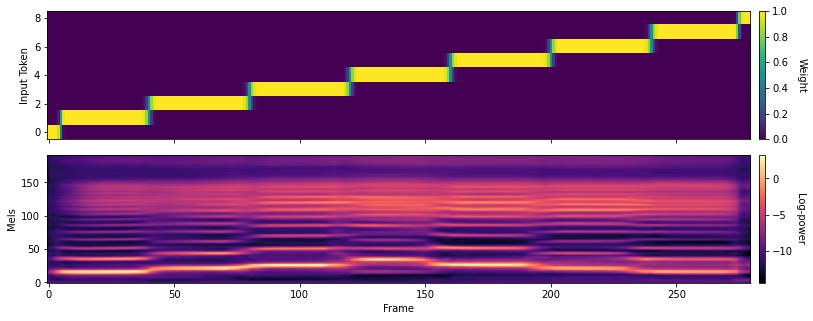

In [13]:
singer = torch.tensor([singers2idx["female1"]], dtype=torch.long, device=device)
technique = torch.tensor([techniques2idx["straight"]], dtype=torch.long, device=device)
lyrics = torch.tensor([[encoding.encode(START)] + [encoding.encode(vowel2arpabet[vowel]) for vowel in "iiiiiii"] + [encoding.encode(END)]], dtype=torch.long, device=device).transpose(0, 1)
pitches = torch.tensor([[0, 60, 64, 67, 72, 67, 64, 60, 0]], dtype=torch.long, device=device).transpose(0, 1)
durations = torch.tensor([[0, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=torch.float, device=device).transpose(0, 1)
tempo = torch.tensor([60.0], device=device)

model.eval()
with torch.no_grad():
    output = model.infer(
        singer,
        technique,
        lyrics,
        pitches,
        durations,
        tempo)

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

im = axs[1].imshow(output[1].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma')
cbar = fig.colorbar(im, pad=0.01, ax=axs[1])
cbar.ax.get_yaxis().labelpad = 12
cbar.ax.set_ylabel("Log-power", rotation=270)

# im = axs[1].imshow(output[1].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma')
# cbar = fig.colorbar(im, pad=0.01, ax=axs[1])
# cbar.ax.get_yaxis().labelpad = 10
# cbar.ax.set_ylabel("Log-power", rotation=270)

im = axs[0].imshow(output[2].squeeze().cpu(), origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')
cbar = fig.colorbar(im, pad=0.01, ax=axs[0])
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel("Weight", rotation=270)

axs[0].set_ylabel("Input Token")
axs[1].set_ylabel("Mels")
axs[1].set_xlabel("Frame")

fig.subplots_adjust(wspace=0.035, hspace=0.12)
plt.show()

In [102]:
output_2=output

In [101]:
def note2f(n):
    return 2 ** ((n - 69) / 12.0) * 440.0
def f2mel(f):
    return 2595 * torch.log10(1 + (f / 700.0))
def mel2bin(m):
    return torch.round(((m - f2mel(torch.tensor(80.0))) / f2mel(torch.tensor(8000.0))) * 192.0)
    
notes_2 = note2f(pitches)
notes_2 = mel2bin(f2mel(notes_2))

In [106]:
frame_durs_2 = (durations.squeeze() * (40.0 / 2)).cumsum(dim=0)
frame_durs_2 = torch.cat((torch.zeros((1,)), frame_durs_2), dim=0)
frame_durs_2 = list(zip(frame_durs_2[:-1], frame_durs_2[1:]))

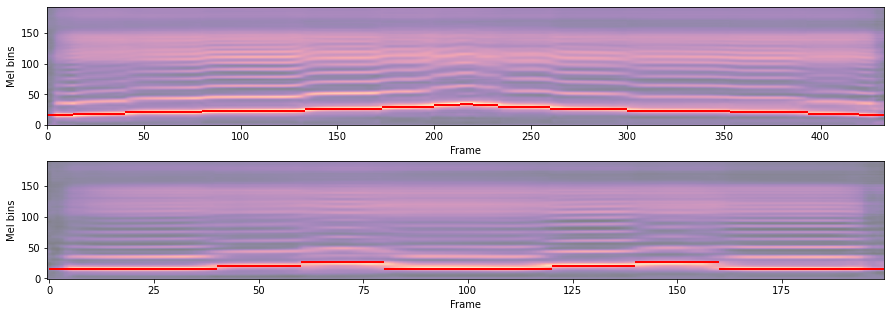

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].imshow(output_1[1].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma', alpha=0.5)
for durs, note in zip(frame_durs_1, notes_1):
    ax[0].plot(durs, [note, note], color='red', linewidth=2.0, solid_capstyle='butt', alpha=1)
ax[0].set_ylim(0, 192)
ax[0].set_xlim(0, output_1[1].squeeze().shape[0])

ax[1].imshow(output_2[1].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma', alpha=0.5)
for durs, note in zip(frame_durs_2, notes_2):
    ax[1].plot(durs, [note, note], color='red', linewidth=2.0, solid_capstyle='butt', alpha=1)
ax[1].set_ylim(-0.5, 192-0.5)
ax[1].set_xlim(-0.5, output_2[1].squeeze().shape[0]-0.5)

ax[0].set_ylabel("Mel bins")
ax[0].set_xlabel("Frame")
ax[1].set_ylabel("Mel bins")
ax[1].set_xlabel("Frame")

fig.subplots_adjust(hspace=0.3)
plt.show()

In [14]:
output[1].shape

torch.Size([433, 1, 192])

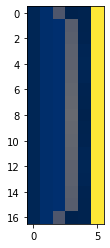

In [283]:
combined = torch.cat([singer.unsqueeze(0).expand((lyrics.shape[0], -1)), technique.unsqueeze(0).expand((lyrics.shape[0], -1)), lyrics, pitches, durations, tempo.unsqueeze(0).expand((lyrics.shape[0], -1))], dim=1)
# combined = F.normalize(combined, p=0, dim=0)
plt.imshow(combined, cmap='cividis')

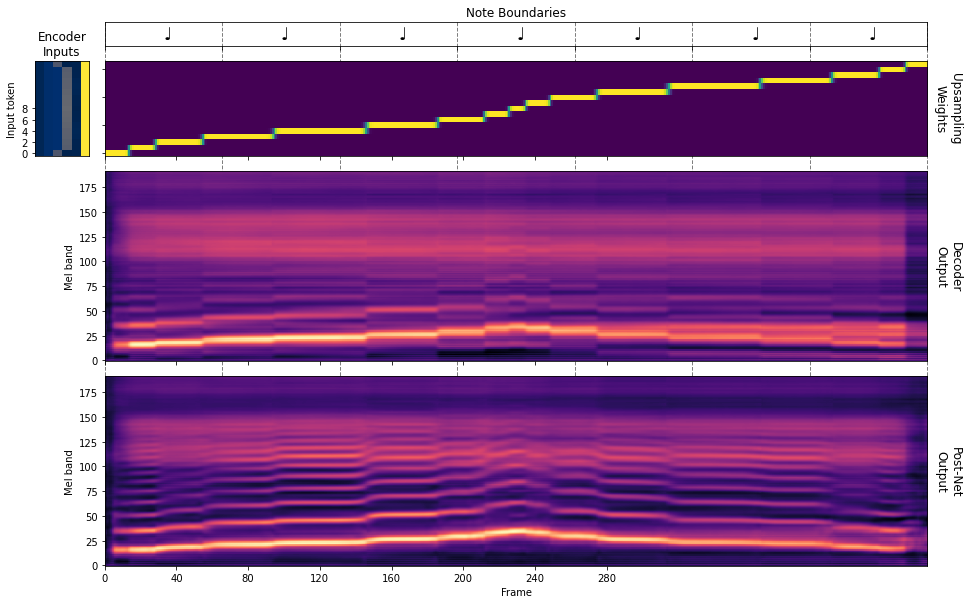

In [284]:
fig, axs = plt.subplots(4, 2, figsize=(16, 10), gridspec_kw={"width_ratios": [1, 15], "height_ratios":[1, 4, 8, 8]})
axs[0][0].axis('off')

axs[0][1].set_xticklabels([])
axs[0][1].set_xticks([0, 40, 80, 120, 160, 200, 240, 280])
axs[0][1].set_yticklabels([])
axs[0][1].set_yticks([])
axs[0][1].set_title("Note Boundaries")
axs[0][1].text(20, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(60, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(100, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(140, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(180, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(220, 0.28, "♩", fontsize='xx-large')
axs[0][1].text(260, 0.28, "♩", fontsize='xx-large')

axs[1][0].imshow(combined, aspect='auto', cmap='cividis', origin='lower')
axs[1][0].set_title("Encoder\nInputs")
axs[1][0].set_ylabel("Input token")
axs[1][0].set_xticks([])
axs[1][0].set_yticks([0, 2, 4, 6, 8])

axs[1][1].imshow(output[2].squeeze().cpu(), origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')
axs[1][1].set_title("Upsampling\nWeights", rotation=270, x=1.025,y=0.1)
axs[1][1].set_xticklabels([])
axs[1][1].set_yticklabels([])
axs[1][1].set_xticks([-0.5, 39.5, 79.5, 119.5, 159.5, 199.5, 239.5, 279.5])

axs[2][1].imshow(output[0].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma')
axs[2][1].set_title("Decoder\nOutput", rotation=270, x=1.025,y=0.35)
axs[2][1].set_ylabel("Mel band")
axs[2][1].set_xticks([-0.5, 39.5, 79.5, 119.5, 159.5, 199.5, 239.5, 279.5])
axs[2][1].set_xticklabels([])
axs[2][0].axis('off')

axs[3][1].imshow(output[1].squeeze().cpu().transpose(0, 1), origin='lower', aspect='auto', cmap='magma')
axs[3][1].set_title("Post-Net\nOutput", rotation=270, x=1.025,y=0.35)
axs[3][1].set_ylabel("Mel band")
axs[3][1].set_xlabel("Frame")
axs[3][1].set_xticks([-0.5, 39.5, 79.5, 119.5, 159.5, 199.5, 239.5, 279.5])
axs[3][1].set_xticklabels([0, 40, 80, 120, 160, 200, 240, 280])
axs[3][0].axis('off')

ll = axs[0][1].plot([0, 0],     [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([40, 40],   [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([80, 80],   [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([120, 120], [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([160, 160], [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([200, 200], [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([240, 240], [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
ll = axs[0][1].plot([280, 280], [1,-16.5], '--k', alpha=0.5, linewidth=1, zorder=999999)
ll[0].set_clip_on(False) 
axs[0][1].set_ylim(0, 1)
axs[0][1].set_xlim(-0, 280.0)

fig.subplots_adjust(wspace=0.035, hspace=0.12)

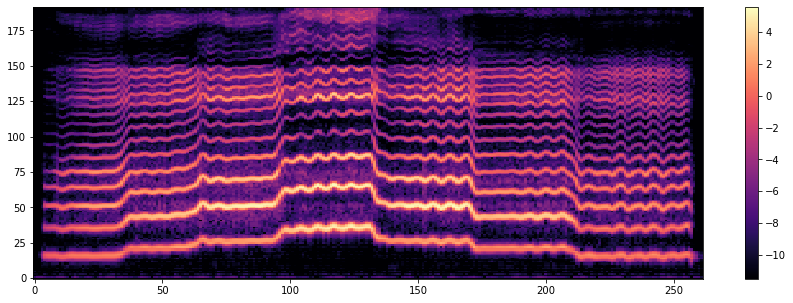

In [35]:
w, sr = torchaudio.load('data/VocalSet\\data_by_singer/female1\\arpeggios/straight\\f1_arpeggios_straight_a.wav')
w = torchaudio.transforms.MelSpectrogram(n_fft=800,n_mels=192,f_min=80.0,f_max=8000)(torchaudio.transforms.Vad(16000)((torchaudio.transforms.Vad(16000)(torchaudio.transforms.Resample(44100)(w)).fliplr())).fliplr())
w = DynamicRangeCompression()(w)

fig, ax = plt.subplots(figsize=(15, 5))
im = ax.imshow(w.squeeze(),
            aspect='auto',
            origin='lower',
            interpolation='nearest',
            cmap='magma')
fig.colorbar(im)

torch.save(w.squeeze(1), 'f1_arpeggios_straight_a_ref.pt')

In [14]:
torch.save(output[1].squeeze(1), 'f1_arpeggios_straight_i.pt')